# Hello PyGraphistry[ai] - HackerNews visual semantic search with UMAP & BERT.

`PyGraphistry[ai]` can quickly create visual graph search interfaces for structured text. It automates much of the work in cleaning, connecting, encoding, searching, and visualing graph data. The result is increasing the *time to graph* and overall results in as little as one line of code.

This notebook shows how to turn 3,000 HackerNews articles into an interactive visual graph with full semantic search. The core flow is a short number of lines and trains in 2 minutes on a CPU and 100-200x faster on GPU. The notebooks carefully demonstrate how to create a fast automatic feature engineering pipeline, which exposes matrices and targets, a Scikits like API, full semantic search over the data which returns dataframes or subgraphs from the query, and `GNN` models and pipelines.

Outline:

* load the data into a graphistry instance, `g = graphistry.nodes(dataframe)`
* since we do not have explicit edges, we will create a similarity graph using UMAP, `g.umap(..)` 
    which will call the `g.featurize(...)` api to create features, then UMAP them, adding an implicit edge dataframe which you can access with `g._edges` (with `g._nodes` the original dataframe) 
* Once the models are built we can search the data and display subgraphs from the search query itself
    using `g.search(query)` and `g.search_graph(query).plot()`
* Transforming on new data using `g.transform(..)`, useful for online or API driven endpoints after a data model has been set
* lastly, create a DGL GNN data model `g.build_gnn(...)` which may be used for downstream `GNN` modeling

Searching over data is useful to refine and find sugraphs over the global corpus of documents/events/data. Search can be operationalized over logs data (see morpheus demo), eCommerce (see clickstream and user-item-recommendation demo), stock and coin data (see crypto-slim demo), OSINT data, etc.

`GNN`s built over these feature encodings are useful for downstream modeling like link prediction, node classification, motif mining and other popular graph AI pipelines. 

In [2]:
#! pip install --upgrade graphistry[ai]   # get the latest graphistry AI 

In [4]:
import os
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import graphistry

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 200)

In [5]:
alpha = 1/137
np.random.seed(int(alpha**-1))  

In [6]:
# add your hub credentials here
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username = os.environ['USERNAME'], password=os.environ['GRAPHISTRY_PASSWORD'])

In [7]:
# get the data top 3000 posts on Hacker News
df = pd.read_csv('https://storage.googleapis.com/cohere-assets/blog/text-clustering/data/askhn3k_df.csv', index_col=0)

In [8]:
good_cols = ['title', 'text']

In [9]:
df.columns

Index(['title', 'url', 'text', 'dead', 'by', 'score', 'time', 'timestamp',
       'type', 'id', 'parent', 'descendants', 'ranking', 'deleted'],
      dtype='object')

In [10]:
df.head()  # see the dataset

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,"I'm a software engineer going blind, how should I prepare?",NaN,"I&#x27;m a 24 y&#x2F;o full stack engineer (I know some of you are rolling your eyes right now, just highlighting that I have experience on frontend apps as well as backend architecture). I&#x27;v...",NaN,zachrip,3270,1587332026,2020-04-19 21:33:46+00:00,story,22918980,NaN,473.0,NaN,NaN
1,Am I the longest-serving programmer – 57 years and counting?,NaN,"In May of 1963, I started my first full-time job as a computer programmer for Mitchell Engineering Company, a supplier of steel buildings. At Mitchell, I developed programs in Fortran II on an IB...",NaN,genedangelo,2634,1590890024,2020-05-31 01:53:44+00:00,story,23366546,NaN,531.0,NaN,NaN
2,Is S3 down?,NaN,I&#x27;m getting<p>{\n &quot;errorCode&quot; : &quot;InternalError&quot;\n}<p>When I attempt to use the AWS Console to view s3,NaN,iamdeedubs,2589,1488303958,2017-02-28 17:45:58+00:00,story,13755673,NaN,1055.0,NaN,NaN
3,What tech job would let me get away with the least real work possible?,NaN,"Hey HN,<p>I&#x27;ll probably get a lot of flak for this. Sorry.<p>I&#x27;m an average developer looking for ways to work as little as humanely possible.<p>The pandemic made me realize that I do no...",NaN,lmueongoqx,2022,1617784863,2021-04-07 08:41:03+00:00,story,26721951,NaN,1091.0,NaN,NaN
4,What books changed the way you think about almost everything?,NaN,I was reflecting today about how often I think about Freakonomics. I don&#x27;t study it religiously. I read it one time more than 10 years ago. I can only remember maybe a single specific anecdot...,NaN,anderspitman,2009,1549387905,2019-02-05 17:31:45+00:00,story,19087418,NaN,1165.0,NaN,NaN


In [11]:
df[good_cols].head()

,title,text
0,"I'm a software engineer going blind, how should I prepare?","I&#x27;m a 24 y&#x2F;o full stack engineer (I know some of you are rolling your eyes right now, just highlighting that I have experience on frontend apps as well as backend architecture). I&#x27;v..."
1,Am I the longest-serving programmer – 57 years and counting?,"In May of 1963, I started my first full-time job as a computer programmer for Mitchell Engineering Company, a supplier of steel buildings. At Mitchell, I developed programs in Fortran II on an IB..."
2,Is S3 down?,I&#x27;m getting<p>{\n &quot;errorCode&quot; : &quot;InternalError&quot;\n}<p>When I attempt to use the AWS Console to view s3
3,What tech job would let me get away with the least real work possible?,"Hey HN,<p>I&#x27;ll probably get a lot of flak for this. Sorry.<p>I&#x27;m an average developer looking for ways to work as little as humanely possible.<p>The pandemic made me realize that I do no..."
4,What books changed the way you think about almost everything?,I was reflecting today about how often I think about Freakonomics. I don&#x27;t study it religiously. I read it one time more than 10 years ago. I can only remember maybe a single specific anecdot...


# Featurize and Encode the Data

In [12]:
from time import time
t0 = time()
################################################################
## Two Lines of codes cuts through 80% of the datasciencing 

df = df.sample(3000) # set smaller if you want to test a minibatch 

################################################################
# create the graphistry instance
g = graphistry.nodes(df)

# set to False if you want to reload last trained instance
process = True

print('-'*80)
if process:
    # Umap will create a similarity graph from the features which we can view as a graph
    g2 = g.umap(X=['title'], # the features to encode (can add/remove 'text', etc)
                y=['score'], # for demonstrative purposes, we include a target -- though this one is not really conditioned on textual features in a straightforward way
                model_name='msmarco-distilbert-base-v2', #'paraphrase-MiniLM-L6-v2', etc, from sbert/Huggingface, the text encoding model
                min_words = 0, # when 0 forces all X=[..] as textually encoded, higher values would ascertain if a column is textual or not depending on average number of words per column
                use_ngrams=False, # set to True if you want ngram features instead (does not make great plots but useful for other situations)
                use_scaler_target='standard', # for regressive targets
                use_scaler=None, # there are many more settings see `g.featurize?` and `g.umap?` for further options
               )
    g2.save_search_instance('data/hn.search')
    print(f'Encoding {df.shape[0]} records using {str(g2._node_encoder.text_model)[:19]} took {(time()-t0)/60:.2f} minutes')
else:
    # or load the search instance
    g2 = g.load_search_instance('data/hn.search')
    print(f'Loaded saved instance')
    
################################################################


--------------------------------------------------------------------------------


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Encoding 3000 records using SentenceTransformer took 1.53 minutes


In [13]:
# see all the data
g2.plot()

In [14]:
# get the encoded features, and use in downstream models (clf.fit(x, y), etc)
x=g2._get_feature('nodes')
# same as 
x = g2._node_features
# same as
x = g2.get_matrix()
x

,title_0,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,...,title_758,title_759,title_760,title_761,title_762,title_763,title_764,title_765,title_766,title_767
1654,0.604488,0.101652,-0.063497,0.307542,0.844374,0.197561,0.896631,0.631857,0.315805,-0.578581,...,-0.042918,-0.322729,-0.277031,-0.319512,-0.165631,-0.584383,0.261868,0.429799,-0.303072,-0.377494
1538,-1.103507,-0.835217,-1.237520,0.549196,0.397246,0.199831,-1.196874,0.290311,-1.171076,0.513540,...,0.006427,-0.731422,-0.750713,-0.486637,0.841622,-0.198652,0.195885,-0.570250,0.050978,-0.436235
2708,0.326092,0.045712,0.308224,0.803963,-0.063246,-0.123905,-0.731468,0.227643,0.261804,-0.048012,...,-0.206501,0.034402,0.796114,-0.237042,0.117702,0.649347,-0.299433,0.995765,-0.009557,-0.119748
62,0.926326,-0.392618,0.035194,-0.161504,-0.326212,-0.166737,0.070937,0.950549,-0.228309,-0.056017,...,-0.551132,0.639072,-0.468963,-0.290477,0.117795,-0.803580,0.804826,0.423588,-0.092650,-0.687976
1481,0.384588,-0.832760,0.033876,0.215492,0.593188,-0.432190,-0.283562,0.400813,0.045255,-0.430429,...,0.028084,-0.152095,-0.226646,0.208703,0.187091,0.133619,0.486250,0.575210,0.730881,-0.129466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,-0.098364,-0.276086,0.550586,0.542078,0.321339,-0.601650,-0.540975,-0.333377,0.094011,0.031201,...,-0.266734,-1.171137,0.190349,-1.094334,-0.939085,0.294115,-0.118376,-0.473456,-0.321870,0.111786
1171,0.702274,-0.091761,0.348669,-0.431706,1.191116,0.006005,-1.105823,-0.625805,-0.168052,0.075096,...,0.838124,-0.305236,0.398299,0.156232,0.146867,0.339570,-0.152106,-0.456346,-0.393480,0.293989
589,-0.406301,-0.531044,-0.563821,-0.012661,0.380232,0.187900,0.169093,0.475025,-0.772457,0.188258,...,-0.478902,-0.781922,0.135231,0.847367,0.451199,0.420809,0.683643,-0.713218,0.390578,-0.141390
2342,0.128966,0.168480,0.055048,-0.287427,-0.069591,-0.533780,-0.401158,-0.270016,-0.398377,0.062334,...,1.068983,-0.483162,-0.373780,-0.411517,0.044580,0.602551,0.423918,0.028719,-0.160396,0.211980


In [15]:
# likewise with the (scaled) targets
y = g2._get_target('nodes')
# same as 
y = g2._node_target
# same as
y = g2.get_matrix(target=True)
y

,score
1654,-0.38835
1538,-0.33530
2708,-0.71150
62,2.70326
1481,-0.31601
...,...
1264,-0.19060
1171,-0.13273
589,0.44605
2342,-0.62951


In [16]:
# visualize the results where we prune edges using the `filter_weighted_edges` method
# this keeps all weights that are (more similar) 0.5 and above. The initial layout is the same (given by umap in 2d)
g25 = g2.filter_weighted_edges(0.5)
g25.plot(render=True)

# Let's query the graph

In [17]:
# direct keyword search when fuzzy=False and a set of columns are given, does not require featurization
g.search('love', fuzzy=False, cols=['title'])[0][['title']]

,title
1647,Is it normal to fall out of love with coding?
1412,What landing page do you love?
2854,Hackers falling in love
2770,What do you love/hate about terminals? Would you change them?
1182,Have you found something you love to do? If yes how?


In [19]:
g2.search('love')[0][['title']]

,title
2532,How did you find your passion?
1182,Have you found something you love to do? If yes how?
2509,After almost 30 years the romance is over - What now?
2669,Is it better to be good at many things or great at one thing?
1164,My wife needs something to do from home to make money...
2469,Does success in work bring you happiness?
2177,As an adult introvertish nerd what makes you happy?
1650,Anxiety is limiting my enjoyment of a wonderful career. Can you relate?
1853,What do you wish you had done/known in your 30s?
1360,Turning 40 soon – seeking personal and professional life advice


In [20]:
# Query semantically instead of strict keyword matching

sample_queries = ['Is true love possible?', 
                  'How to create deep learning models?', 
                  'Best tech careers',
                  'How do I make more money?', 
                  'Advances in particle physics', 
                  'Best apps and gadgets', 
                  'Graph Neural Networks', 
                  'recommend impactful books', 
                  'lamenting about life']

for query in sample_queries:
    print('*'*33)
    print(query)
    print('*'*30)
    # use the featurized instance g2 for semantic search
    results_df, encoded_query_vector = g2.search(query)
    print(results_df['title'])
    print('-'*60)

*********************************
Is true love possible?
******************************
1182             Have you found something you love to do? If yes how?
2043        Why aren't there many credible online bachelors programs?
2509            After almost 30 years the romance is over - What now?
2469                        Does success in work bring you happiness?
2532                                   How did you find your passion?
1569             What do you wish you had known before you turned 40?
2669    Is it better to be good at many things or great at one thing?
1853                 What do you wish you had done/known in your 30s?
1198            What are the books you wish your colleagues had read?
400                                        What Lived Up to the Hype?
Name: title, dtype: object
------------------------------------------------------------
*********************************
How to create deep learning models?
******************************
35                     

# Search to Graph

We may also query and create a graph of results. This returns the nodes found during `g.search` and then pulls in any edges of those nodes in both the `src` AND `dst` or, with `broader=True`, with nodes in `src` OR `dst` -- the latter can be useful in user-relationship-item/user/behavioral datasets and recommendation strategies where NLP search can help recall/create ontologically similar mini-batches to broaden scope. 

In [21]:
gr = g2.search_graph('How to create deep learning models', thresh=15, top_n=50, scale=0.25, broader=False) 
gr.plot()

In [22]:
g2.search_graph('Graph Neural Networks', thresh=50, top_n=50, scale=0.1, broader=False).plot()

In [24]:
g2.search_graph('fraud detection algorithms', thresh=50, top_n=50, scale=0.1, broader=False).plot()  # works better if you encode 'text' column as well

# To Demonstrate transforming on new or unseen data (imagine a train test split or new mini batch)

In [25]:
sdf = df.sample(10)
x, y = g2.transform(sdf, sdf, return_graph=False)  # or edges if given or already produced through umap-ing the ny_nodes=
                                                                #and if neither, set `embedding=True` for random embedding of size `n_topics`
x

,title_0,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,...,title_758,title_759,title_760,title_761,title_762,title_763,title_764,title_765,title_766,title_767
1517,0.979180,0.041072,-0.593098,0.214304,0.962338,-0.713328,-0.989697,0.145388,0.075608,0.488215,...,-0.696708,0.139317,-0.846404,-0.025490,-0.120986,-0.055843,0.637930,0.143514,0.585826,-0.303448
1605,0.688653,0.019184,-0.227892,-0.239211,0.189795,0.341207,-0.120877,-1.296878,0.206908,0.103815,...,-0.236452,-0.384294,0.394059,0.244530,-0.364924,0.675864,-0.271245,-0.173634,-0.298026,-0.017564
1451,-0.184770,0.235804,-0.400443,-0.211511,0.114818,0.160413,-0.131262,0.500900,-0.275231,0.190890,...,0.091999,-0.233226,-0.072699,-0.713460,0.423684,1.398612,-0.203436,0.473697,-0.219005,-0.128714
1372,-0.983680,0.548434,-0.584351,0.353703,0.117870,-0.098879,1.095775,-0.385954,-0.541251,0.007578,...,0.047079,0.485933,-0.285741,-0.035659,-0.101807,0.110145,1.122281,-0.237854,-0.532332,0.939817
964,-0.431375,-0.915085,-0.580861,0.395472,0.406366,-0.131193,1.074949,-0.996813,-0.183665,-0.006735,...,-0.946300,0.433078,-0.190154,0.137894,-0.198106,-0.261280,-0.695857,0.226295,-0.670496,-0.423368
1104,0.096140,-0.056172,0.063150,0.234838,0.117753,-0.346006,-0.744430,-0.151107,0.143060,0.241910,...,0.500574,-0.478188,0.296040,-0.612845,-0.324935,-0.439464,0.469710,0.539491,0.906302,-0.175188
37,0.281097,-0.608663,0.423599,0.420787,1.051380,-0.027290,0.602898,-0.284727,0.099539,-1.925934,...,-0.300906,-0.111235,1.123893,0.459886,-0.218124,0.590245,0.296381,-0.609109,-0.147541,-1.250704
228,-0.131974,-0.062444,-0.837820,0.162044,-0.451466,0.319139,0.052473,-0.631871,-0.020183,-0.478724,...,-0.101025,1.011868,-0.704747,-0.454947,-0.227243,0.961758,0.686837,0.510259,0.270457,-1.069947
1340,0.634322,0.351494,0.038098,0.234291,-0.872616,-0.458497,-0.179605,0.256817,0.122679,0.471110,...,0.682162,0.184881,0.382003,0.236048,0.035794,-0.462713,0.333054,0.447952,0.912596,0.432614
1681,-0.244261,-0.050637,-0.474688,0.063758,-0.309980,-0.171460,-0.609836,-0.007839,-0.371513,0.509530,...,-0.222305,-1.502060,-0.571068,-1.054443,-0.434218,-0.145071,0.131197,-0.685201,0.055874,0.055352


Likewise, we can `transform_umap` to get the embedding coordinates as well

In [26]:
emb, x, y = g2.transform_umap(df.sample(10), df.sample(10), return_graph=False)
emb.head()

,x,y
2178,12.067898,5.299919
1227,11.831199,4.594526
684,-3.108138,4.623506
1733,10.267467,6.992209
702,11.229530,7.411973


# Build a GNN model 

In [27]:
# this inherets all the arguments from the g.featurize api for both nodes and edges, see g.build_gnn? for details
g3 = g25.build_gnn(y_nodes='score')  # we use the filtered edges graphistry instance as it has higher fidelity similarity scores on edges
                        # ie, less edges

In [28]:
g3.get_matrix(kind='edges').head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,_weight
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.797920
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.547040
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.862698
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.801896
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.653791


In [29]:
# Since edges are featurized, we can transform on "unseen/batch" ones
edge_data = g3._edges.sample(10)

# y_edges will be None since we don't have a label for the implicit edges. One could supply it via enrichment (like clustering, annotation etc)
x_edges, _ = g3.transform(edge_data, None, kind='edges', return_graph=False)
x_edges.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,_weight
7043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
10633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
1180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
6769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724311
47201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.514489


In [30]:
# once built, we can get the DGL graph itself
G = g3.DGL_graph
G

Graph(num_nodes=3000, num_edges=19100,
      ndata_schemes={'feature': Scheme(shape=(768,), dtype=torch.float32), 'target': Scheme(shape=(1,), dtype=torch.float64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'feature': Scheme(shape=(3001,), dtype=torch.float64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)})

In [31]:
# the features, targets, and masks
G.ndata

{'feature': tensor([[ 0.6045,  0.1017, -0.0635,  ...,  0.4298, -0.3031, -0.3775],
        [-1.1035, -0.8352, -1.2375,  ..., -0.5702,  0.0510, -0.4362],
        [ 0.3261,  0.0457,  0.3082,  ...,  0.9958, -0.0096, -0.1197],
        ...,
        [-0.4063, -0.5310, -0.5638,  ..., -0.7132,  0.3906, -0.1414],
        [ 0.1290,  0.1685,  0.0550,  ...,  0.0287, -0.1604,  0.2120],
        [-0.1442,  0.7037, -0.8524,  ...,  0.0048, -0.0208,  0.0272]]), 'target': tensor([[-0.3883],
        [-0.3353],
        [-0.7115],
        ...,
        [ 0.4461],
        [-0.6295],
        [-0.7211]], dtype=torch.float64), 'train_mask': tensor([True, True, True,  ..., True, True, True]), 'test_mask': tensor([False, False, False,  ..., False, False, False])}

In [32]:
# `build_gnn()` will turn edges gotten from umap into bonafide feature matrices, 
# and make features out of explicit edges with `build_gnn(X_edges=[...], ..)`
G.edata['feature'].shape

torch.Size([19100, 3001])

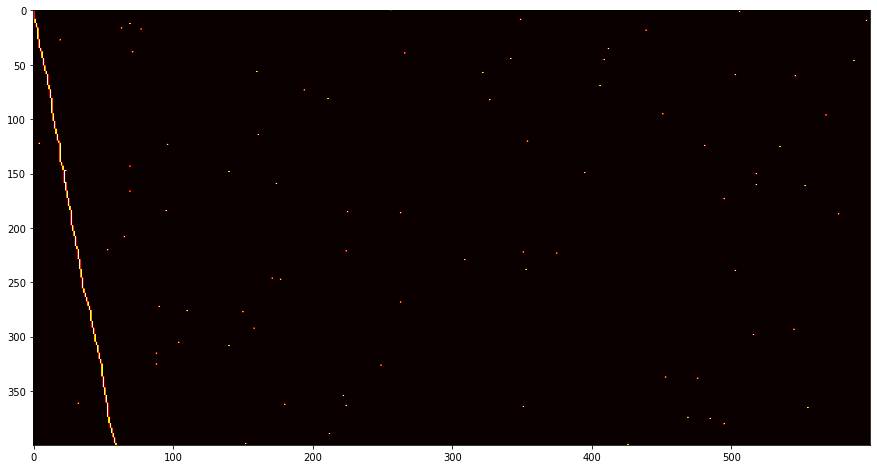

In [33]:
# see the edge features which are shape (n_edges, n_nodes + weight)
# notice that had we used filter_weighted_edges to create a new graphistry instance and then .build_gnn() we would get
# a different n_edges. Useful to keep in mind when building models without an explicit edge_dataframe
plt.figure(figsize=(15,8))
plt.imshow(G.edata['feature'][:400, :600], aspect='auto', cmap='hot')

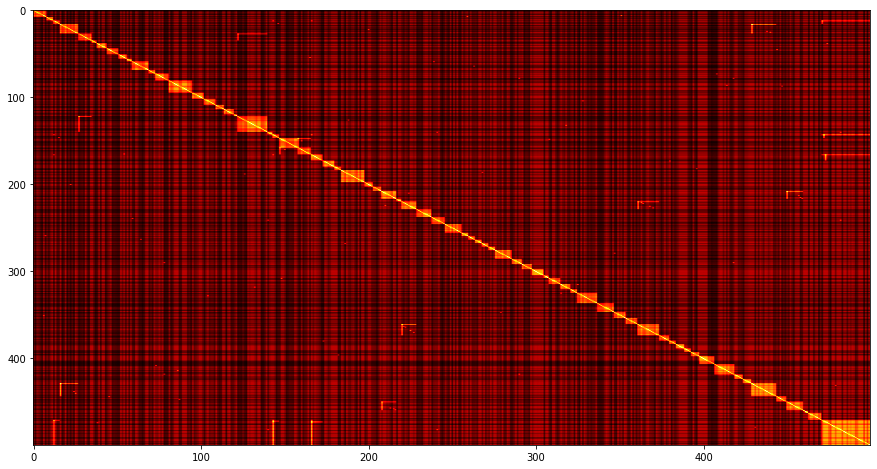

In [34]:
# see the way edges are related across the first 500 edges.
plt.figure(figsize=(15,8))
plt.imshow(np.cov(G.edata['feature'][:500]), aspect='auto', cmap='hot')

In [35]:
# to see how to train a GNN, see the cyber or influence tutorial